In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import skorch
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import numpy as np
import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
from Lung_dataset import ILDDataset

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [3]:
NUM_TOTAL = 1982
NUM_TRAIN = 1500
#add path as absolute path for root dir
lung_dataset_train = ILDDataset(csv_file='/Users/magdy/Desktop/BMI260/Project/Data/Clean_train_test_dataset/Dataset/train_labels.csv', 
                          root_dir='/Users/magdy/Desktop/BMI260/Project/Data/Clean_train_test_dataset/Dataset/train',mask=True, train=True)#, transform=transform)


#add path as absolute path for root dir
lung_dataset_test = ILDDataset(csv_file='/Users/magdy/Desktop/BMI260/Project/Data/Clean_train_test_dataset/Dataset/test_labels.csv', 
                          root_dir='/Users/magdy/Desktop/BMI260/Project/Data/Clean_train_test_dataset/Dataset/test', mask=True, train=False)#, transform=transform)


loader_train = DataLoader(lung_dataset_train, batch_size=32, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(lung_dataset_train, batch_size=32, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTAL)))

loader_test = DataLoader(lung_dataset_test, batch_size=32)

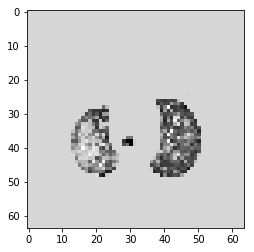

label: 2


In [4]:
#show datasample
sample = lung_dataset_train[120]
plt.imshow(sample[0], cmap='gray')
plt.show()
print("label: " + str(sample[1]))

In [5]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)


In [12]:
def get_model(freeze=False):
    """
    Used to fetch model for classification
    """
#     channel_1 = 64
#     channel_2 = 64
#     channel_3 = 128

#     in_channel = 62
    num_classes = 3

    model = models.resnet50(pretrained=True)
    model.avgpool = nn.AvgPool2d(1, stride=1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1, bias=False)
    if(freeze==True):
        for param in model.parameters():
            param.requires_grad = False
    model.fc = nn.Linear(8192, num_classes)
    model.dropout = nn.Dropout2d(p=0.5)

    
    return model
    # from skorch import NeuralNetClassifier

    # net = NeuralNetClassifier(
    #     module=model,
    #     criterion = nn.CrossEntropyLoss,
    #     optimizer=optim.Adam,
    #     train_split=None,
    #     max_epochs=5,
    #     lr = learning_rate,
    #     warm_start = True,
    #     device = device
    # )

In [13]:
def check_accuracy(loader, model, train=False):
    if loader.dataset.train and train == True:
        print('Checking accuracy on training set')
    elif loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            x.unsqueeze_(1)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [14]:
def train(model, optimizer, epochs=1, overfit=False):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            x.unsqueeze_(1)
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                if(overfit):
                    check_accuracy(loader_train, model, train=True)
                check_accuracy(loader_val, model)
                print()

In [ ]:
model1 = get_model()
optimizer = optim.Adam(model1.parameters(), lr = 0.0001)
train(model1, optimizer, epochs=10, overfit=True)

Iteration 0, loss = 1.1678
Checking accuracy on training set
Got 634 / 1500 correct (42.27)
Checking accuracy on validation set
Got 301 / 482 correct (62.45)

Iteration 0, loss = 0.5761
Checking accuracy on training set
Got 1208 / 1500 correct (80.53)
Checking accuracy on validation set
Got 268 / 482 correct (55.60)

Iteration 0, loss = 0.3937
Checking accuracy on training set
Got 1252 / 1500 correct (83.47)
Checking accuracy on validation set
Got 253 / 482 correct (52.49)

Iteration 0, loss = 0.3184
Checking accuracy on training set
Got 1366 / 1500 correct (91.07)
Checking accuracy on validation set
Got 251 / 482 correct (52.07)

Iteration 0, loss = 0.0989
Checking accuracy on training set
Got 1387 / 1500 correct (92.47)
Checking accuracy on validation set
Got 272 / 482 correct (56.43)

Iteration 0, loss = 0.1672
Checking accuracy on training set
Got 1411 / 1500 correct (94.07)
Checking accuracy on validation set
Got 248 / 482 correct (51.45)

Iteration 0, loss = 0.1728
Checking accur

In [17]:
best_model = model

In [11]:
model = get_model()
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
train(model, optimizer, epochs=10, overfit=True)

Iteration 0, loss = 1.1195
Checking accuracy on training set
Got 520 / 1500 correct (34.67)
Checking accuracy on validation set
Got 248 / 482 correct (51.45)

Iteration 0, loss = 0.7336
Checking accuracy on training set
Got 1120 / 1500 correct (74.67)
Checking accuracy on validation set
Got 240 / 482 correct (49.79)

Iteration 0, loss = 0.3912
Checking accuracy on training set
Got 1272 / 1500 correct (84.80)
Checking accuracy on validation set
Got 250 / 482 correct (51.87)

Iteration 0, loss = 0.6592
Checking accuracy on training set
Got 1321 / 1500 correct (88.07)
Checking accuracy on validation set
Got 294 / 482 correct (61.00)

Iteration 0, loss = 0.1504
Checking accuracy on training set
Got 1398 / 1500 correct (93.20)
Checking accuracy on validation set
Got 265 / 482 correct (54.98)

Iteration 0, loss = 0.2289
Checking accuracy on training set
Got 1390 / 1500 correct (92.67)
Checking accuracy on validation set
Got 263 / 482 correct (54.56)

Iteration 0, loss = 0.2539
Checking accur

In [10]:
#Check validation set
check_accuracy(loader_val, model)

Checking accuracy on validation set
Got 249 / 482 correct (51.66)


In [ ]:
# from sklearn.model_selection import KFold
# from sklearn import metrics

# # for epoch in range(5):
# kf = KFold(n_splits=3, shuffle = True)
# accuracies=[]
# for train_index, test_index in kf.split(x):
#     accuracies=[]
# #     (N, C1, C2, S) = x.shape 
# #     x = x.reshape((N, 62, 512, 512))
# #     y = y.reshape((y.shape[0]))
# #     print(x.shape)
# #     print(y.shape)
# #     print(train_index)
# #     print(test_index)
#     xk_train, xk_test = x[train_index], x[test_index]
#     yk_train, yk_test = y[train_index], y[test_index]
#     net.fit(xk_train,yk_train)
#     y_pred = net.predict(xk_test)
#     acc = metrics.accuracy_score(yk_test, y_pred)
#     accuracies.append(acc)
#     print('FinalAccuracy %.4f' % (np.mean(accuracies)))

In [11]:
#Check Test set
check_accuracy(loader_test, model)

Checking accuracy on test set
Got 121 / 375 correct (32.27)
